In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [5]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [6]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [7]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)
    #Yb = Yb.type(torch.LongTensor)

    return Xb, Yb

#todo: mettre les shapes a cote

In [8]:
d_model = 64
embed_dim = 32

In [65]:
class RecurrentUnit(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(embed_dim+d_model, d_model)

    def forward(self, x, h_prev):
        h = self.fc(torch.cat([x, h_prev], dim=1))
        h = F.tanh(h)
        return h
    
class GatedRecurrentUnit(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_z = nn.Linear(embed_dim+d_model, d_model)
        self.fc_r = nn.Linear(embed_dim+d_model, d_model)
        self.fc_h_hat = nn.Linear(embed_dim+d_model, d_model)

    def forward(self, x, h_prev):
        z = F.sigmoid(self.fc_z(torch.cat([x, h_prev], dim=1)))
        r = F.sigmoid(self.fc_r(torch.cat([x, h_prev], dim=1)))
        h_hat = F.tanh(self.fc_h_hat(torch.cat([x, r * h_prev], dim=1))) # * = torch.mul
        h = (1 - z) * h_prev + z * h_hat

        #r permet de remove/reset des infos/channels de h_prev
        #on utilise alors ce hidden state comme candidat pour le suivant, h_hat
        #z permet de controler quels channels (de l'hidden state) update

        return h

class RNN_LM(nn.Module):
    def __init__(self):
        super().__init__()

        self.h0 = nn.Parameter(torch.zeros(1, d_model))
        self.embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0)
        self.cell = RecurrentUnit()
        #self.cell = GatedRecurrentUnit()
        self.lm_head = nn.Linear(d_model, len(vocabulaire))

    def forward(self, x, targets=None):
        # x : (B, T)
        # targets : (B, T)

        B, T = x.size()

        emb = self.embed(x) # (B, T, embed_dim)

        H_prev = self.h0.expand((B, -1)) # (B, d_model)
        hiddens = []
        for t in range(T):
            X_t = emb[:, t, :] #todo : remove last : # todo shape (B, embed_dim)
            H_t = self.cell(X_t, H_prev) # (B, d_model)
            H_prev = H_t
            hiddens.append(H_t)

        hidden = torch.stack(hiddens, 1) # (B, T, d_model)
        logits = self.lm_head(hidden) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)
        
        return logits, loss
    
    def sample(self, prompt='', max_new_tokens=None):
        init_len = len(prompt)+1

        #convert prompt to (1, T) input tensor X
        X = torch.zeros(size=(1, init_len), dtype=torch.int64, device=device) #<SOS>

        X[0, 0] = 1 #<SOS>
        for i, ch in enumerate(prompt):
            X[0, i+1] = char_to_int[ch]

        # forward is 2 fold : one when we feed in the prompt, one for autoregressive gen

        #prompt feeding
        h_prev = self.h0
        emb = self.embed(X)
        for t in range(init_len):
            x_t = emb[:, t, :]
            h_t = self.cell(x_t, h_prev)
            h_prev = h_t
            
        #autoregressive gen
        while True:
            logits = self.lm_head(h_prev) # (1, vocab_size)
            probs = F.softmax(logits, dim=1)

            next_token = torch.multinomial(probs, num_samples=1, replacement=True).item()
            next_char = int_to_char[next_token]

            if next_char == '<EOS>':
                break
                
            prompt += next_char

            if len(prompt)-init_len+1 == max_new_tokens:
                break

            w_t = next_token #entry for next timestep
            x_t = self.embed(torch.tensor(w_t, dtype=torch.int64, device=device)).view(1, -1)
            h_t = self.cell(x_t, h_prev)
            h_prev = h_t
        
        return prompt
    
class RNN_wAttention_LM(nn.Module):
    def __init__(self):
        super().__init__()

        d_key = d_model

        self.h0 = nn.Parameter(torch.zeros(1, d_model))
        self.embed = nn.Embedding(len(vocabulaire), embed_dim, padding_idx=0)
        self.cell = RecurrentUnit()
        #self.cell = GatedRecurrentUnit()
        self.h_to_key = nn.Linear(d_model, d_key)

        self.lm_head = nn.Linear(d_model+d_key, len(vocabulaire))

    def forward(self, x, targets=None):
        # x : (B, T)
        # targets : (B, T)

        B, T = x.size()

        emb = self.embed(x) # (B, T, embed_dim)

        H_prev = self.h0.expand((B, -1)) # (B, d_model)
        hiddens = []
        for t in range(T):
            X_t = emb[:, t, :] #todo : remove last : # todo shape (B, embed_dim)
            H_t = self.cell(X_t, H_prev) # (B, d_model)
            H_prev = H_t
            hiddens.append(H_t)

        hidden = torch.stack(hiddens, 1) # (B, T, d_model)

        Q = hidden # (B, T, d_model)
        K = self.h_to_key(torch.cat([self.h0.expand((B, 1, -1)), hidden], 1)) # (B, T+1, d_key=d_model)

        QK_T = Q @ torch.transpose(K, 1, 2) # (B, T, T+1) lignes = originaires (querys), colonnes = targets (keys) c'est pour ça que il y en a T+1

        mask = torch.tril(torch.ones((T, T+1), dtype=torch.int32)).bool()
        QK_T[:, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T, dim=2) # (B, T, T+1)
        attention_out = attention_scores @ K # (B, T, d_key=d_model)

        pre_logits = torch.cat([hidden, attention_out], dim=2) # (B, T, 2*d_model)
        logits = self.lm_head(pre_logits) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)
        
        return logits, loss
    
    def sample(self, prompt='', max_new_tokens=None):
        init_len = len(prompt)+1

        #convert prompt to (1, T) input tensor X
        X = torch.zeros(size=(1, init_len), dtype=torch.int64, device=device) #<SOS>

        X[0, 0] = 1 #<SOS>
        for i, ch in enumerate(prompt):
            X[0, i+1] = char_to_int[ch]

        # forward is 2 fold : one when we feed in the prompt, one for autoregressive gen

        #prompt feeding
        h_prev = self.h0
        hiddens = []
        emb = self.embed(X)
        for t in range(init_len):
            x_t = emb[:, t, :]
            h_t = self.cell(x_t, h_prev)
            h_prev = h_t
            hiddens.append(h_t)
        
        hidden = torch.stack(hiddens, 1) # (1, init_len, d_model)

        #autoregressive gen
        while True:
            q = h_prev.expand(1, 1, -1) # (1, 1, d_model)
            K = self.h_to_key(torch.cat([self.h0.expand((1, 1, -1)), hidden], 1)) # (1, init_len+num_tokens_generated, d_key=d_model)

            qK_T = q @ torch.transpose(K, 1, 2) # (1, 1, init_len+num_tokens_generated)

            mask = torch.zeros(size=(1, qK_T.shape[2])) # (1, init_len+num_tokens_generated)
            mask[0, -1] = 1
            mask = mask.bool()
            qK_T[:, mask] = -float("inf")

            attention_scores = torch.softmax(qK_T, dim=2) # (1, 1, init_len+num_tokens_gen)
            attention_out = attention_scores @ K # (1, 1, d_key=d_model)
            attention_out = torch.squeeze(attention_out, dim=0)
            
            pre_logits = torch.cat([h_prev, attention_out], dim=1) # (1, 2*d_model)

            logits = self.lm_head(pre_logits) # (1, vocab_size)
            probs = F.softmax(logits, dim=1)

            next_token = torch.multinomial(probs, num_samples=1, replacement=True).item()
            next_char = int_to_char[next_token]

            if next_char == '<EOS>':
                break
                
            prompt += next_char

            if len(prompt)-init_len+1 == max_new_tokens:
                break

            w_t = next_token #entry for next timestep
            x_t = self.embed(torch.tensor(w_t, dtype=torch.int64, device=device)).view(1, -1)
            h_t = self.cell(x_t, h_prev)
            h_prev = h_t
            hiddens.append(h_t)
            hidden = torch.stack(hiddens, 1) # (1, init_len+num_tokens_generated, d_model)
        
        return prompt
    
#todo : bien remettre en place les notations, afin de pouvoir en faire un report
#todo : report avec losscape

In [66]:
g = torch.Generator().manual_seed(42)
#model = RNN_LM()
model = RNN_wAttention_LM()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.01)

In [67]:
total_params = sum(p.numel() for p in model.parameters())
total_params

17838

In [68]:
lossi = []

In [71]:
for _ in range(1000):
    Xb, Yb = get_batch('train', 1024)

    #forward
    logits, loss = model(Xb, Yb)

    lossi.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

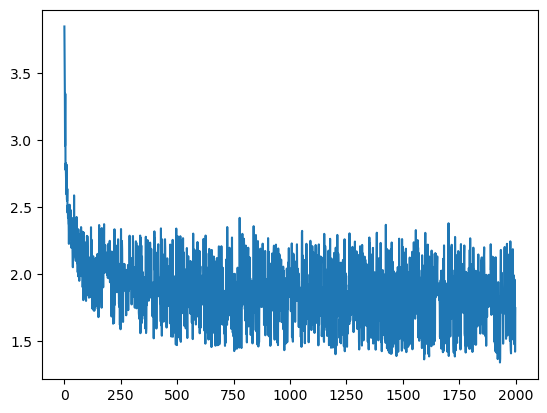

In [72]:
plt.plot(lossi)

In [74]:
for _ in range(10):
    print(model.sample())

saint-gillémargues
lartignac
bonnes
la buzillon
chéran
therval
plouria
belloy
wrépiège
vernac


In [363]:
villes_gen = []

for _ in range(1000):
    villes_gen.append(model.sample(""))

In [364]:
lens_gen = [len(ville) for ville in villes_gen]
occurences_lens = [0] * (max(lens_gen)+1)

for ville in villes_gen:
    occurences_lens[len(ville)] += 1

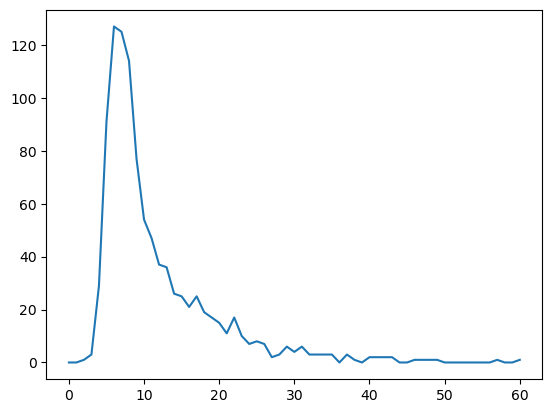

In [365]:
plt.plot(occurences_lens)